# Python API to new modules at https://argovis.colorado.edu

The [Argo](http://www.argo.ucsd.edu/index.html) program has provided temperature, salinity and pressure data (T/S/P) on a global scale.

The webapp [Argovis](http://argovis.colorado.edu) provides data access and visualizatoin. 

The following code is an interface to some of the new features at Argovis. Recently we have been including other data sets and data derived gridded products. API access is available for these datasets so that those inclined can retrive Argovis data in a python environment.

This script will guide a python user to:

[1. Query Profiles co-located with Atmospheric Rivers](#section_one)

[2. Create contour plot of Float Trajectory data around the Drake Passage](#section_two)

[3. Query atmospheric rivers](#section_three)

Argovis API basics were covered in an [earlier post](https://www.itsonlyamodel.us/argovis-python-api.html).

In [167]:
import requests
import pandas as pd
import numpy as np
import cmocean
import matplotlib.pylab as plt
from scipy.interpolate import griddata
from datetime import datetime, timedelta
import pdb
import os

#used for map projections
from netCDF4 import Dataset as netcdf_dataset
import cartopy.crs as ccrs

%matplotlib inline

#sets plot styles
import seaborn as sns
from matplotlib import rc
from matplotlib import rcParams
import matplotlib.ticker as mtick
rc('text', usetex=False)
rcStyle = {"font.size": 10,
           "axes.titlesize": 20,
           "axes.labelsize": 20,
           'xtick.labelsize': 16,
           'ytick.labelsize': 16}
sns.set_context("paper", rc=rcStyle)
sns.set_style("whitegrid", {'axes.grid' : False})
myColors = ["windows blue", "amber", "dusty rose", "prussian blue", "faded green", "dusty purple", "gold", "dark pink", "green", "red", "brown"]
colorsBW = ["black", "grey"]
sns.set_palette(sns.xkcd_palette(myColors))

curDir = os.getcwd()
docDir = os.path.join(curDir, 'docs')

<a name="section_one"/> </a>
# Atmospheric Rivers

Atmospheric rivers (AR) are wet masses of air that that transport water vapor from the tropics. Ever heard of the Pineapple Express? It is when an atmospheric river forms around Hawaii and ends at the western end of North America. The pineapple express events have been known to drop several inches of rain and snow in normally dry arid regions, ending droughts, and even causing mudslides. Atmospheric rivers are studied in detail, and are a major factor in metrological systems. One question regarding these bodies of water is how do they affect the sea? Normally oceans get sparse rain. Do AR increase rain percipitation, does all the rain fall on land?

Argo may be able to tell us. Floats measuring sea surface salinity and temperature under atmospheric rivers can tell us if the sea salinity has changed before, during, and after an atmospheric river event.

Data gathered from [Guan-Walister](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2015JD024257) takes shapes of atmospheric rivers and adds them to the Argovis database. Shapes are queried by date-time and displayed [here](https://argovis.colorado.edu/ng/ar).

//insert image here

If you want to get the data into Python, consider getting started with the following API. In this example, we find a set of ARs occuring on January 1st 2010 at 12am. We then pick a Pineapple Express and plot it in python. Next, we use the same AR shape to query Argo profiles that fall within $\pm 3$ days from this event.

In [74]:
def get_ar_by_date(date):
    url = "https://argovis.colorado.edu/arShapes/findByDate?date="
    url += date
    resp = requests.get(url)
    if not resp.status_code // 100 == 2:
        return "Error: Unexpected response {}".format(resp)
    ars = resp.json()
    return ars

def format_ars(ars):
    for ar in ars:
        coords = ar['geoLocation']['coordinates']
        del ar['geoLocation']
        longs, lats = list(zip(*coords))
        ar['coords'] = coords
        ar['longs'] = list(longs)
        ar['lats'] = list(lats)
    return ars

format_date_api = lambda date: datetime.strftime(date, "%Y-%m-%dT%H:%M:%SZ")

In [75]:
date = datetime(2010, 1, 1, 0, 0, 0)
dateStr = format_date_api(date)
ars = get_ar_by_date(dateStr)
ars = format_ars(ars)
arDf = pd.DataFrame(ars)

In [84]:
arDf.head()

,_id,coords,date,date_formatted,id,lats,longs,shapeId
0,1_262992.0,"[[-179.375, -73.5], [-180, -73.5], [-181.25, -...",2010-01-01T00:00:00.000Z,2010-01-01,1_262992.0,"[-73.5, -73.5, -73, -73, -73, -73, -73, -72.5,...","[-179.375, -180, -181.25, -181.875, -182.5, -1...",1
1,2_262992.0,"[[30, -70.5], [28.75, -71], [28.125, -71], [27...",2010-01-01T00:00:00.000Z,2010-01-01,2_262992.0,"[-70.5, -71, -71, -71, -71, -71, -71, -71.5, -...","[30, 28.75, 28.125, 27.5, 26.875, 26.25, 25.62...",2
2,3_262992.0,"[[-115.625, 37], [-118.125, 36], [-118.75, 37]...",2010-01-01T00:00:00.000Z,2010-01-01,3_262992.0,"[37, 36, 37, 38, 39.5, 39.5, 39, 38.5, 38, 37....","[-115.625, -118.125, -118.75, -119.375, -122.5...",3
3,4_262992.0,"[[143.125, 47.5], [142.5, 47], [141.875, 47], ...",2010-01-01T00:00:00.000Z,2010-01-01,4_262992.0,"[47.5, 47, 47, 46.5, 46, 45.5, 45.5, 46, 47.5,...","[143.125, 142.5, 141.875, 140.625, 140, 138.75...",4
4,5_262992.0,"[[-41.25, 48], [-41.875, 48], [-43.125, 48.5],...",2010-01-01T00:00:00.000Z,2010-01-01,5_262992.0,"[48, 48, 48.5, 48.5, 49, 49, 49.5, 50, 50.5, 5...","[-41.25, -41.875, -43.125, -43.75, -45, -45.62...",5


In [168]:
def get_selection_profiles(startDate, endDate, shape, presRange=None):
    baseURL = 'https://argovis.colorado.edu/selection/profiles'
    startDateQuery = '?startDate=' + startDate
    endDateQuery = '&endDate=' + endDate
    shapeQuery = '&shape='+shape
    if not presRange == None:
        pressRangeQuery = '&presRange=' + presRange
        url = baseURL + startDateQuery + endDateQuery + pressRangeQuery + shapeQuery
    else:
        url = baseURL + startDateQuery + endDateQuery + shapeQuery
    resp = requests.get(url)
    # Consider any status other than 2xx an error
    if not resp.status_code // 100 == 2:
        return "Error: Unexpected response {}".format(resp)
    selectionProfiles = resp.json()
    return selectionProfiles

def parse_into_df(profiles):
    meas_keys = profiles[0]['measurements'][0].keys()
    df = pd.DataFrame(columns=meas_keys)
    for profile in profiles:
        profileDf = pd.DataFrame(profile['measurements'])
        profileDf['cycle_number'] = profile['cycle_number']
        profileDf['profile_id'] = profile['_id']
        profileDf['lat'] = profile['lat']
        profileDf['lon'] = profile['lon']
        profileDf['date'] = profile['date']
        df = pd.concat([df, profileDf], sort=False)
    return df

stringify_array = lambda arr: str(arr).replace(' ', '')

In [169]:
presRange='[0,30]'
startDate = format_date_api(date - timedelta(days=3))
endDate = format_date_api(date + timedelta(days=3))
ar = arDf.iloc[2]
coords = list(zip(ar.longs, ar.lats))
coords = [list(elem) for elem in coords]
shape = stringify_array([coords])

In [170]:
profiles = get_selection_profiles(startDate, endDate, shape, presRange)
profileDf = parse_into_df(profiles)
pdf = profileDf.drop_duplicates(subset='profile_id')

In [171]:
pdf.head()

,pres,psal,temp,cycle_number,profile_id,lat,lon,date
0,5.5,35.392,21.512,97.0,5901759_97,27.448,-145.995,2010-01-02T19:31:48.000Z
0,5.7,35.511,22.681,122.0,5901336_122,25.165,-158.639,2010-01-02T12:35:27.000Z
0,5.5,35.488,22.040,97.0,5901757_97,25.868,-154.894,2010-01-02T02:22:05.088Z
0,5.5,35.448,21.640,97.0,5901756_97,26.966,-148.599,2010-01-02T00:39:58.464Z
0,5.5,34.832,19.976,46.0,5902210_46,28.997,-143.873,2010-01-01T21:54:46.656Z


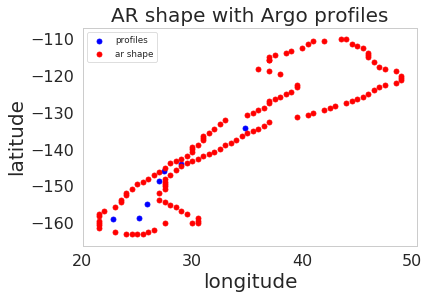

In [121]:
def plot_profiles_and_ar(pdf, ar):
    fig = plt.figure()
    axes = plt.axes()
    px, py = pdf.lat.values, pdf.lon.values
    ax, ay = ar.lats, ar.longs
    axes.scatter(px,py,marker='o',c='b',s=25)
    axes.scatter(ax,ay,marker='o',c='r',s=25)
    axes.set_title('AR shape with Argo profiles')
    axes.set_ylabel('latitude')
    axes.set_xlabel('longitude')
    axes.legend(['profiles', 'ar shape'])
    return fig

fig1 = plot_profiles_and_ar(pdf, ar)

There were seven profiles falling within this AR shape. Determining the effect of AR on these profiles is beyond the scope of this lession. Hopefully there is someone smarter than me who can find if there is a connection between atmospheric rivers and sea surface salinity!

<a name="section_two"/> </a>
# Float trajectory covariance

Argo floats are deployed world wide. They freely float with the currents, eddies, and gyres. Each time the floats rise, their satalite systems estimate their position. A floats trajectory is pretty well known, but is there a way to estimate the trajectory? A collegue of mine has generated a model that attempts such a thing. We stored the trajectory estimation data from his research on Argovis [here](https://argovis.colorado.edu/ng/covar)

//insert image here

The data that Argovis displays can be retrieved by the following API.  In this example, we create a contour plot in python of data around the Drake Passage between Chile and Antartica.

In [334]:
long = -60
lat = -58
dt = 120
def get_float_trajectory_by_point_and_dt(long, lat, dt):
    url = "https://argovis.colorado.edu/covarGrid/"
    url += str(long) + '/'
    url += str(lat) + '/'
    url += str(dt)
    resp = requests.get(url)
    if not resp.status_code // 100 == 2:
        return "Error: Unexpected response {}".format(resp)
    traj = resp.json()
    return traj

traj = get_float_trajectory_by_point_and_dt(long, lat, dt)
features = traj['features']
latLng = [ (row['geometry']['coordinates'][1], row['geometry']['coordinates'][0]) for row in features]

In [335]:
latLngProb = [ (row['geometry']['coordinates'][1], \
                row['geometry']['coordinates'][0], \
                row['properties']['Probability'] ) for row in features]
x, y, z = [], [], []
for row in latLngProb:
    x.append(row[0])
    y.append(row[1])
    z.append(row[2])

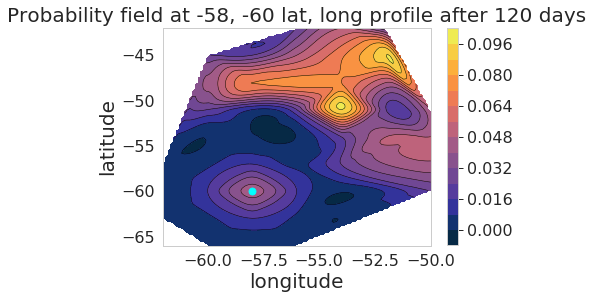

In [338]:
def contour_plot(x, y, z, dt, lat, long):
    fig = plt.figure()
    axes = plt.axes()
    xi = np.linspace(np.min(x),np.max(x),100)
    yi = np.linspace(np.min(y),np.max(y),100)
    
    zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='cubic')
    CS = plt.contour(xi,yi,zi,15,linewidths=0.5,colors='k')
    CS = plt.contourf(xi,yi,zi,15,cmap=cmocean.cm.thermal)
    axes.scatter(lat, long, marker='o', c='cyan', s=50)
    axes.set_title('Probability field at {1}, {2} lat, long profile after {0} days'.format(dt, lat, long))

    axes.set_ylabel('latitude')
    axes.set_xlabel('longitude')
    cbar = fig.colorbar(CS, cmap = cmocean.cm.thermal)
    return fig

fig = contour_plot(x, y, z, dt, lat, long)

We can see there is a high probability that a float locacted at the Cyan dot will travel North East after 120 days of drifting. We can also see that cubic interpolation outputs regions of high probability in places that are missing from the data!

<a name="section_three"/> </a>
# Gridded data

The data Argo Floats measurements scattered about the ocean can be interpolated into uniform grids. There are many products derived argo floats [here](http://www.argo.ucsd.edu/Gridded_fields.html). Comparing grids is difficult. You would have to download each gridded product and try to link them up yourself. Fortunatly, Argovis is working displaying and providing gridded products data. For example, see the Roemmich Gilson Climatology Grid at 10 decibar depth on January 2012 off the coast of Western Austrailia. Here we show the anomaly.

//insert image here

In this example we will recreate what is shown in this image in python. Furthermore we will perform cosine area averaging over to find the spatially averaged anomaly.

In [317]:
lonRange = [101.5,123]
latRange = [-41.5,-14.5]
gridName = 'rgTempAnom'
monthYear = '01-2012'
presLevel = str(10)
def get_grid(latRange, lonRange, gridName, monthYear, presLevel):
    url = "https://argovis.colorado.edu/griddedProducts/grid/window?"
    url += "latRange=" + stringify_array(latRange)
    url += "&lonRange=" + stringify_array(lonRange)
    url += "&gridName=" + gridName
    url += "&monthYear=" + monthYear
    url += "&presLevel=" + presLevel
    resp = requests.get(url)
    if not resp.status_code // 100 == 2:
        return "Error: Unexpected response {}".format(resp)
    grid = resp.json()
    return grid[0] # should be a list of length 1

grid = get_grid(latRange, lonRange, gridName, monthYear, presLevel)

In [318]:
print(grid.keys())
xllCorner = grid['xllCorner']
yllCorner = grid['yllCorner']
nCols = grid['nCols']
nRows = grid['nRows']
cellXSize = grid['cellXSize']
cellYSize = grid['cellYSize']
zs = np.array(grid['zs'], dtype=np.float)
zs = np.reshape(zs, (nRows, nCols))

longs = xllCorner + cellXSize * np.arange(0, nCols)
lats = yllCorner + cellYSize * np.arange(0, nRows)[::-1]

longGrid, latGrid = np.meshgrid(longs, lats)

dict_keys(['_id', 'pres', 'date', 'measurement', 'units', 'param', 'variable', 'cellXSize', 'cellYSize', 'noDataValue', 'gridName', 'zs', 'nRows', 'nCols', 'xllCorner', 'yllCorner'])


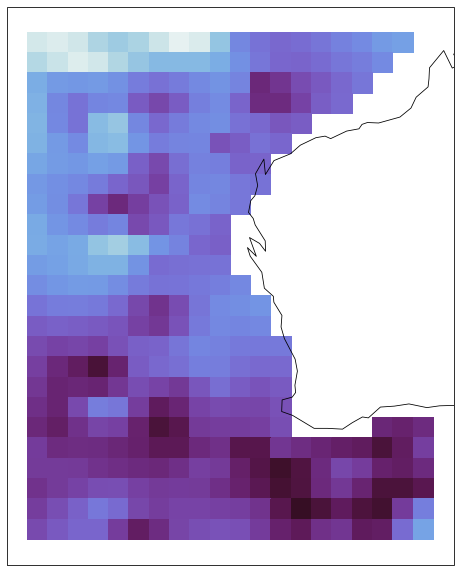

In [319]:
def plot_pmesh(xx, yy, zs):
    fig = plt.figure(figsize=(8,12))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines(zorder=1)
    plt.pcolormesh(xx, yy, zs, cmap=cmocean.cm.dense, transform=ccrs.PlateCarree(),zorder=0)
    return fig
fig = plot_pmesh(longGrid, latGrid, zs)

## Weighted averaging

Our grid is comprised of cells with uniform distances. But sense they are on a sphere, spatially averaging them requires there to be weights. We are no longer averaging on a Cartesian surface. 

$$
\bar{X} = \frac{\int_{\Omega} X(\lambda, \phi) dA}{\int dA} = \frac{1}{A}\int_{\Omega} X(\lambda, \phi) dA
$$

Where $\lambda$ and $\phi$ are longitude and latitude in radians. $\Omega$ represents a sphere. The discrete approximation of this integral is
$$
\bar{X} = \frac{1}{\Sigma^n_i cos(\phi_i)} \Sigma^n_i X_i cos(\phi_i)
$$

where $i$ is our grid index and n is are the total elements. The following python code implementats this on our gridded data.

In [326]:
def get_area_avg(longGrid, latGrid, zs):
    z = zs.flatten()
    nanIdx = ~np.isnan(z)
    z = z[nanIdx]
    longs = longGrid.flatten()[nanIdx]
    lats = latGrid.flatten()[nanIdx]
    latsR = np.deg2rad(lats)
    weights = np.cos(latsR)
    zav = np.average(z, weights=weights)    
    return zav 

zav = get_area_avg(longGrid, latGrid, zs)
print("Area Averaged Anomaly: {}".format(zav))

Area Averaged Anomaly: 1.7434573998970153


# Conclusion

The following code can be implmented in other langauges such as R and Matlab. Anything with an HTTP requests library should be able to get data from Argovis. This project is still new, and will continue to evolve and improve. Feel free to email tyler.tucker@colorado.edu for questions/requests. Thanks!